In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cotengra as ctg
from src.post_cost_sa import SA_kalachev
from src.post_cost_trees import *
from src.circuit import get_random_circuit

## Example for a shallow circuit

In [2]:
# Build an example circuit

n = 64 # number of qubits
m = 6 # depth
# the hyperoptimizers set up below in cotengra should already have cached results (included) and will pull them instead of running.
qc = get_random_circuit(n, m)

# Now add a final layer of gates tagged with a keyword 'post tensor'.
# This will be used to sort out which tensors in the amplitude tensor network we're optimizing are associated with the measurement basis:

for j in range(n):
    qc.apply_gate('Z',j,tags = 'post tensor')

In [3]:
# Get the amplitude of the output '0...0' state from this circuit (quimb object).
# Various simplifications are applied by default:

tn_amp = qc.amplitude_tn(n*'0') 


# Right now my code assumes each index in the TN takes on two values, which is what quimb does when creating TNs for the circuits we have. This
# can easily be modified to read in more general TNs in the future, but right now let's just verify that it's ok:

for tn in tn_amp:
    if max(tn.shape) > 2: print('WARNING: code is not currently designed to handle indices with dimension > 2')

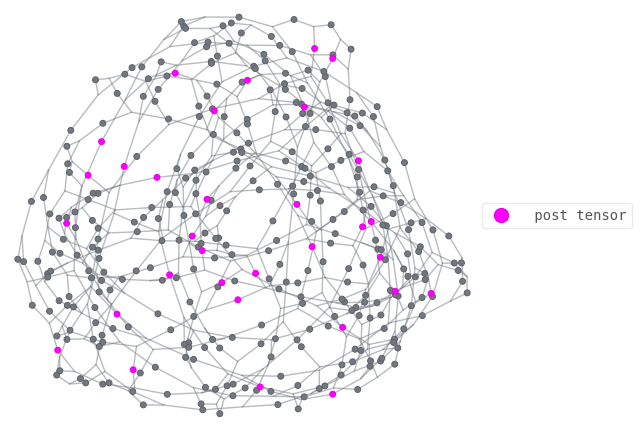

In [4]:
# This cell takes ~10 seconds to run at the default n,m used here:

tn_amp.select('post tensor', which='all') # call out the post tensors as special
tn_amp.draw(color = ['post tensor'], custom_colors = ['magenta']) # Draw TN, highlighting the post tensors

In [5]:
# Set up a reasonably high quality cotengra hyperoptimizer

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    minimize='flops', 
    optlib='random',
    max_repeats=128,
    max_time="rate:1e2",
    directory=True,
    progbar=True,
    parallel = False
)

#Get an optimized contraction tree from Cotengra

tree_ctg = tn_amp.contraction_tree(opt, output_inds=())

c_ctg = tree_ctg.contraction_cost() # cost of tree
c_sv = float(n*m*2**n) # approximate cost of state-vector simulation (proxy for TN cost in the limit of large m/depth)

F=10.60 C=11.99 S=30.00 P=31.32:  84%|████████▎ | 107/128 [03:54<00:47,  2.24s/it]/Users/E935202/test_cert_rand/jpmc-argonne-certified-rand/Cert2/final_code/test_env/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:329: UserWarning: Trial error: cannot import name 'UtilityFunction' from 'bayes_opt' (/Users/E935202/test_cert_rand/jpmc-argonne-certified-rand/Cert2/final_code/test_env/lib/python3.10/site-packages/bayes_opt/__init__.py). Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
F=10.60 C=11.99 S=30.00 P=31.32: 100%|██████████| 128/128 [04:39<00:00,  2.19s/it]


In [6]:
# Get a list of tensors and post-tensors in the format my ContractionTree class expects:

tensors, post_tensors = tn_from_quimb_amp(tn_amp)

# Form a tree object out of them (by default, the tree is intialized as a random ballanced tree):

tree = ContractionTree(tensors,post_tensors)


# Seed my tree with the tree generated from Cotengra
tree.from_ctg_tree(tree_ctg)

In [7]:
costs, post_costs = SA_kalachev(tree, tinit = 2e1, tfin = 1e-1, tsteps = 1e4, inplace = False, pre_weight = 0.01, progress = True)

100%|████████████████████| 10000/10000 [00:13<00:00, 765.44it/s]


Cost ration of SA vs CTG:  0.9999999986983402
Post-cost to Cost ration:  0.9999997376654947


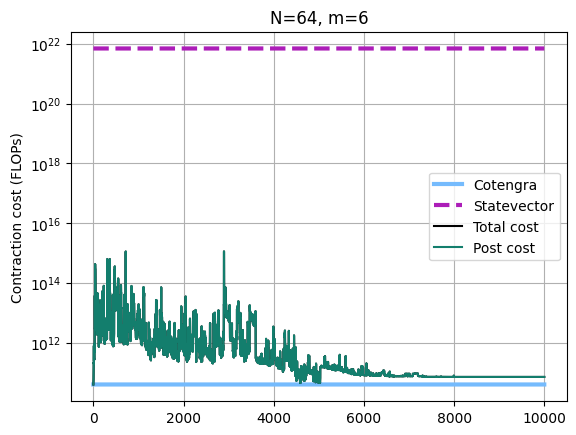

In [8]:
costs = np.array(costs).astype(np.float64)
post_costs = np.array(post_costs).astype(np.float64)

skip = 1 # To reduce plotting burdern, increase if you have more than ~ 1e4 tsteps above

print('Cost ration of SA vs CTG: ', min(costs)/c_ctg)
print('Post-cost to Cost ration: ', min(post_costs)/min(costs))
plt.plot(len(costs)//skip*[float(c_ctg)], ls = '-', c = 'xkcd:sky blue', label = 'Cotengra', lw = 3)
plt.plot(len(costs)//skip*[float(c_sv)], ls = '--', c = 'xkcd:barney', label = 'Statevector', lw = 3)
plt.plot(costs[::skip], label = 'Total cost', c = 'k')
plt.plot(post_costs[::skip],'-', c = 'xkcd:blue green',  label = 'Post cost')

plt.yscale('log')
plt.xscale('linear')
plt.ylabel('Contraction cost (FLOPs)')

# plt.xlim(7e4,1e5)
# plt.ylim(min(post_costs),1e33)

plt.grid(which = 'both')
plt.title(f'N={n}, m={m}')
plt.legend()
plt.show()

## Example for a deep circuit

In [9]:
n = 64 
m = 12
qc = get_random_circuit(n, m)
for j in range(n):
    qc.apply_gate('Z',j,tags = 'post tensor')
    
tn_amp = qc.amplitude_tn(n*'0') 
for tn in tn_amp:
    if max(tn.shape) > 2: print('WARNING: code is not currently designed to handle indices with dimension > 2')
    
tree_ctg = tn_amp.contraction_tree(opt, output_inds=())
c_ctg = tree_ctg.contraction_cost()
c_sv = float(n*m*2**n)

F=21.56 C=22.98 S=64.00 P=65.00: 100%|██████████| 128/128 [12:03<00:00,  5.65s/it]


In [10]:
tensors, post_tensors = tn_from_quimb_amp(tn_amp)
tree = ContractionTree(tensors,post_tensors)
tree.from_ctg_tree(tree_ctg)

costs, post_costs = SA_kalachev(tree, tinit = 2e1, tfin = 1e-1, tsteps = 1e4, inplace = False, pre_weight = 0.01, progress = True)

100%|████████████████████| 10000/10000 [00:40<00:00, 244.41it/s]


Cost ration of SA vs CTG:  0.8429524660442703
Post-cost to Cost ration:  0.007467624670848949


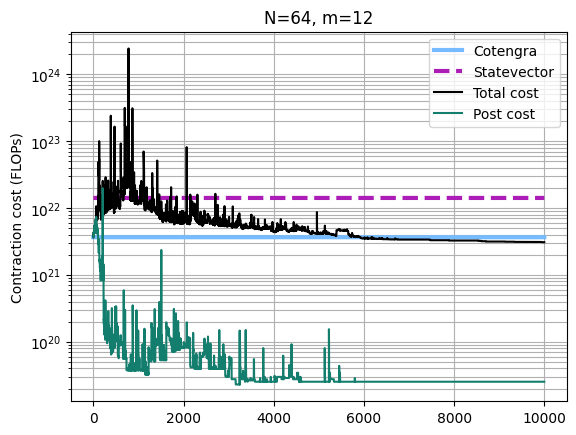

In [11]:
costs = np.array(costs).astype(np.float64)
post_costs = np.array(post_costs).astype(np.float64)

skip = 1 # To reduce plotting burdern, increase if you have more than ~ 1e4 tsteps above

print('Cost ration of SA vs CTG: ', min(costs)/c_ctg)
print('Post-cost to Cost ration: ', min(post_costs)/min(costs))
plt.plot(len(costs)//skip*[float(c_ctg)], ls = '-', c = 'xkcd:sky blue', label = 'Cotengra', lw = 3)
plt.plot(len(costs)//skip*[float(c_sv)], ls = '--', c = 'xkcd:barney', label = 'Statevector', lw = 3)
plt.plot(costs[::skip], label = 'Total cost', c = 'k')
plt.plot(post_costs[::skip],'-', c = 'xkcd:blue green',  label = 'Post cost')

plt.yscale('log')
plt.xscale('linear')
plt.ylabel('Contraction cost (FLOPs)')

# plt.xlim(7e4,1e5)
# plt.ylim(min(post_costs),1e33)

plt.grid(which = 'both')
plt.title(f'N={n}, m={m}')
plt.legend()
plt.show()

## Example for an intermediate depth circuit

In [12]:
n = 64 
m = 8
qc = get_random_circuit(n, m)
for j in range(n):
    qc.apply_gate('Z',j,tags = 'post tensor')
    
tn_amp = qc.amplitude_tn(n*'0') 
for tn in tn_amp:
    if max(tn.shape) > 2: print('WARNING: code is not currently designed to handle indices with dimension > 2')
    
tree_ctg = tn_amp.contraction_tree(opt, output_inds=())
c_ctg = tree_ctg.contraction_cost()
c_sv = float(n*m*2**n)

F=15.45 C=16.81 S=46.00 P=47.32: 100%|██████████| 128/128 [09:34<00:00,  4.49s/it]


In [13]:
tensors, post_tensors = tn_from_quimb_amp(tn_amp)
tree = ContractionTree(tensors,post_tensors)
tree.from_ctg_tree(tree_ctg)

costs, post_costs = SA_kalachev(tree, tinit = 2e1, tfin = 1e-1, tsteps = 1e4, inplace = False, pre_weight = 0.01, progress = True)

100%|████████████████████| 10000/10000 [00:22<00:00, 451.59it/s]


Cost ration of SA vs CTG:  1.00000000000001
Post-cost to Cost ration:  0.9999612385607968


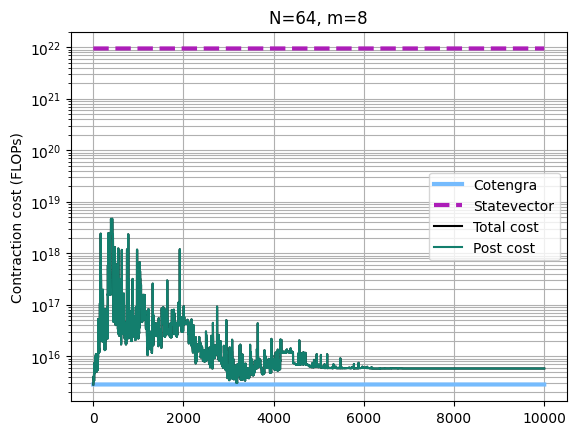

In [14]:
costs = np.array(costs).astype(np.float64)
post_costs = np.array(post_costs).astype(np.float64)

skip = 1 # To reduce plotting burdern, increase if you have more than ~ 1e4 tsteps above

print('Cost ration of SA vs CTG: ', min(costs)/c_ctg)
print('Post-cost to Cost ration: ', min(post_costs)/min(costs))
plt.plot(len(costs)//skip*[float(c_ctg)], ls = '-', c = 'xkcd:sky blue', label = 'Cotengra', lw = 3)
plt.plot(len(costs)//skip*[float(c_sv)], ls = '--', c = 'xkcd:barney', label = 'Statevector', lw = 3)
plt.plot(costs[::skip], label = 'Total cost', c = 'k')
plt.plot(post_costs[::skip],'-', c = 'xkcd:blue green',  label = 'Post cost')

plt.yscale('log')
plt.xscale('linear')
plt.ylabel('Contraction cost (FLOPs)')

# plt.xlim(7e4,1e5)
# plt.ylim(min(post_costs),1e33)

plt.grid(which = 'both')
plt.title(f'N={n}, m={m}')
plt.legend()
plt.show()